In [1]:
import matplotlib.pyplot as plt
import glob, os, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.time import Time
from astropy.table import Table
from gammapy.data import Observation, observatory_locations, EventList
from gammapy.datasets import MapDataset, MapDatasetEventSampler, FluxPointsDataset
from gammapy.estimators import ASmoothMapEstimator, TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import MapDatasetMaker, RingBackgroundMaker, SafeMaskMaker
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.makers import MapDatasetMaker, WobbleRegionsFinder
from gammapy.maps import MapAxis, RegionNDMap, WcsGeom, Map, TimeMapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ConstantSpectralModel,
    FoVBackgroundModel,
    LightCurveTemplateTemporalModel,
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
)
from regions import PointSkyRegion, CircleSkyRegion

from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    PiecewiseNormSpectralModel,
    PowerLawNormSpectralModel,
    LogParabolaSpectralModel,
)

import warnings
from gammapy.visualization import plot_spectrum_datasets_off_regions

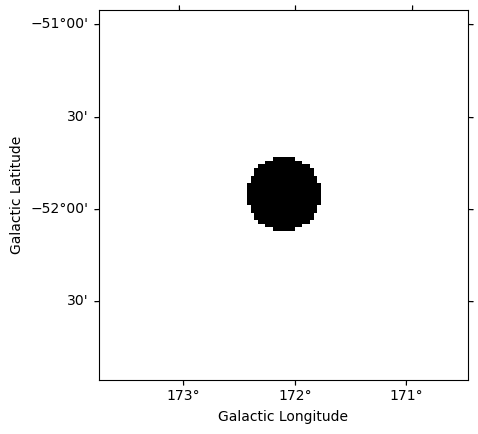

In [2]:
# let's load the previously created Observation index files:
datastore = DataStore.from_dir("./")

observations = datastore.get_observations(obs_id=list(datastore.obs_table['OBS_ID']))

# we consider a square map of size 2.0 deg, spatially binned with bins of 0.02 deg;
# we define the ON region, assuming a circle of 0.2 deg of radius, for the source;
width = 2.0  #deg
binsz = 0.02 #deg
radius= 0.2  #deg

# let's define an exclusion region, in order to better estimate the bkg:
target_position = SkyCoord(40.669 * u.deg, -0.013 * u.deg, frame="icrs", unit="deg")
on_region_radius = Angle(radius * u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

npix = int(width/binsz)

exclusion_region = CircleSkyRegion(
    center=target_position,
    radius=radius * u.deg,
)

geom_excl = WcsGeom.create(
    npix=(npix, npix), binsz=binsz, skydir=target_position.galactic, proj="TAN", frame="galactic"
    #npix=(npix, npix), binsz=binsz, skydir=w1.galactic, proj="TAN", frame="galactic"
)

exclusion_mask = ~geom_excl.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

In [3]:
# Create the reconstruced energy range:
e_min, e_max = 0.1 * u.TeV, 100 * u.TeV

energy_axis = MapAxis.from_energy_bounds(
    e_min, e_max, nbin=5, per_decade=True, unit="TeV", name="energy"
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.01, 300, nbin=10, per_decade=True, unit="TeV", name="energy_true"
)

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to determine the reflected regions, excluding the source region:
maker_fov = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

# let's impone a safe range for the analysis: we consider only events at a distance from the pointing direction < 1 deg.
offset_max = 2 * u.deg
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-default","offset-max"], offset_max=offset_max
)

# create a counts map for visualisation later...
counts = Map.create(skydir=target_position, width=3)

# let's create the dataset for each observation and stack them all:
datasets = Datasets()

# let's loop over observations
for observation in observations:
    # generate a dataset object
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    # fill the dataset with the events of the observation
    counts.fill_events(observation.events)

    # calculate the bkg
    dataset_on_off = maker_fov.run(dataset, observation)
    # set a safe range for the analysis
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

No default upper safe energy threshold defined for obs 1
No default lower safe energy threshold defined for obs 1


/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/regions/shapes/circle.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


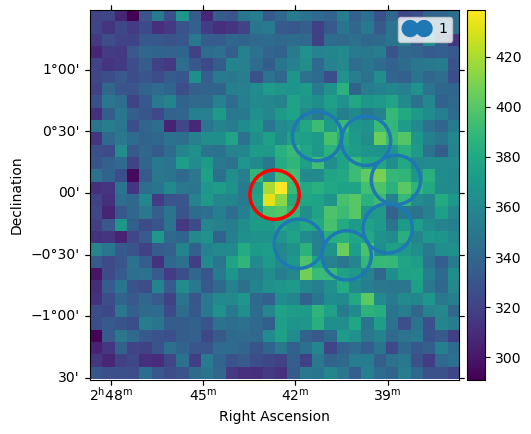

In [4]:
#plot the counts map overimposing the ON-OFF regions
ax = counts.smooth(0.05 * u.deg).plot(stretch="linear", cmap="viridis", add_cbar=True)
geom.plot_region(ax=ax, kwargs_point={"color": "k", "marker": "*"}, color="r", linewidth=2.5)
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets, linewidth=2.5)
plt.show()

In [5]:
# Individual
info_table=datasets.info_table()
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str1,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
1,5003,305.0,4.070118065090561,4698.0,4741.571428571429,4741.571428571429,nan,637098.8074945097,58691459460.346855,39600.0,39600.0,0.12633838383838383,0.11863636363636364,0.007702020202020202,15,15,wstat,27.955496677969933,28188,15.0,90.0,0.16666666666666666


In [6]:
# We can also investigate the cumulative of all the runs:
info_table= datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,5003,305.0,4.07011615084298,4698.0,4741.571549694148,4741.571549694148,nan,637098.8125,58691461120.0,39600.0,39600.0,0.12633838383838383,0.11863636363636364,0.007702020202020202,15,15,wstat,27.955481095595182,28188,15.0,90.0,0.1666666716337204


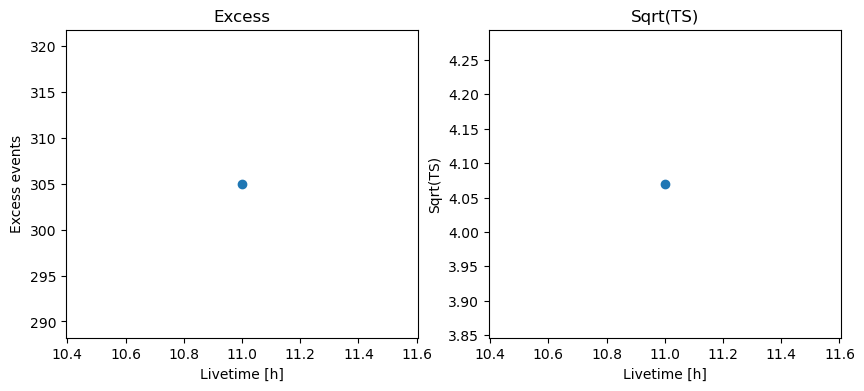

In [7]:
# We can plot the excess and the significance
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

In [8]:
dataset_stacked = Datasets(datasets).stack_reduce()

In [9]:
# let's fit the data with a powerlaw model
spectral_model = PowerLawSpectralModel(index=2.62, amplitude="5e-13 cm-2 s-1 TeV-1", reference="1 TeV")

# make a SkyModel object
model = SkyModel(spectral_model=spectral_model, name="NGC_1068")

# associate the model to the dataset
dataset_stacked.models = model

# set an energy range for the spectral fit
dataset_stacked.mask_fit = dataset_stacked.counts.geom.energy_mask(
    energy_min=0.1 * u.TeV, energy_max=30 * u.TeV
)

# fit the stacked dataset
fit = Fit()
result_stacked = fit.run(dataset_stacked)

print(result_stacked)
print(dataset_stacked.models.parameters.to_table())

# we make a copy here to compare it later
best_fit_model = datasets.models.copy()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 85
	total stat : 11.30

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

type    name     value         unit        error   min max frozen link prior
---- --------- ---------- -------------- --------- --- --- ------ ---- -----
         index 3.4176e+00                5.527e-01 nan nan  False           
     amplitude 4.0808e-14 TeV-1 s-1 cm-2 4.180e-14 nan nan  False           
     reference 1.0000e+00            TeV 0.000e+00 nan nan   True           


In [10]:
dataset_stacked.stat_sum()

np.float64(11.29578077913494)

In [11]:
# I use the energy bins of the dataset. The `downsample` acts reducing the number of bins of a given integer.
#energy_edges = energy_axis.downsample(1).edges 

e_m, e_ma, e_bins = 0.1, 50, 8     #Remember: if you want n bin, you need n+1 
energy_edges = np.logspace(np.log10(e_m), np.log10(e_ma), e_bins) * u.TeV

# let's extract points for the `test_source` model. Errors will be at 1 sigma and upper limits at 3 sigma:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="NGC_1068", selection_optional="all", n_sigma=1, n_sigma_ul=5, n_jobs=7
)
flux_points = fpe.run(datasets=dataset_stacked)

#flux_points.sqrt_ts_threshold_ul = 2

flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,float64[11],bool,float64[1],bool,float64[11]
0.15848931924611137,0.10000000000000002,0.251188643150958,2.2121933405892164e-11,3.938939095687666e-12,5.489340236035106e-13,1.0458777898669709,0.27621536778621353,0.27507911041424216,0.27738173768860297,2.456332680698648,14.803978337149601,3.8475938373416705,3936.2655463814904,255.30992,0.040979760291520506,14.844958097441122,9.665390160080278 .. 182.87830556940753,False,3936.0,True,0.2 .. 4.999999999999999
0.39810717055349726,0.251188643150958,0.6309573444801934,9.501344173857948e-13,4.249533285006288e-13,1.4875861259111106e-13,0.6023243499243025,0.6269674193126664,nan,0.6326299265234053,3.8822400687168033,0.9387214258676977,0.9688763728503744,844.4906479383797,30.072369,2.7225333156529814,3.661254741520679,3.138857588510291 .. 46.36520488086899,True,847.0,True,0.2 .. 4.999999999999999
1.0000000000000002,0.6309573444801934,1.584893192461114,4.08081605950678e-14,4.584618523334548e-14,4.0312904408373646e-14,2.0784537016770464,1.5899882530276384,1.5581942026539952,1.6229629050089214,nan,1.8072067622565555,1.3443239052611373,167.9922988748387,18.157927,0.026790944093136204,1.8339977063496917,1.4953714054358898 .. 3.1621766322191434,True,168.0,True,0.2 .. 4.999999999999999
2.511886431509581,1.584893192461114,3.9810717055349736,1.7527056600420568e-15,4.946125984861217e-15,1.09246129251395e-14,-1.1017960924811083,4.3021039021071354,nan,4.490390967980789,nan,0.06417966325727775,-0.25333705464711975,33.47292939146228,-1.6149182,6.716557461970524,6.780737125227802,6.805810069555832 .. 8.50922653647973,True,33.0,True,0.2 .. 4.999999999999999
6.309573444801934,3.9810717055349736,10.000000000000002,7.527850032806313e-17,5.336139121194702e-16,2.9605201936116196e-15,10.30140052020706,16.710412624619167,nan,nan,nan,0.4193497086986042,0.6475721648577896,13.2888235719648,2.3369687,0.2237452744305557,0.6430949831291599,0.6261779089410879 .. 0.3295704509550177,True,13.0,True,0.2 .. 4.999999999999999
15.848931924611144,10.000000000000002,25.118864315095824,3.233202665361517e-18,5.756905668779388e-17,8.022874473303379e-16,-14.333370379587231,63.04494149236987,nan,nan,nan,0.045383824508355985,-0.21303479647314894,3.069947408950494,-0.4186432,0.045193906112082516,0.0905777306204385,0.09185023369077783 .. 0.1272112444732727,True,3.0,True,0.2 .. 4.999999999999999
31.622776601683817,25.118864315095824,39.810717055349734,3.0503832342876814e-19,4.675229905603647e-18,1.42983168287962e-16,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,nan .. nan,False,0.0,False,0.2 .. 4.999999999999999


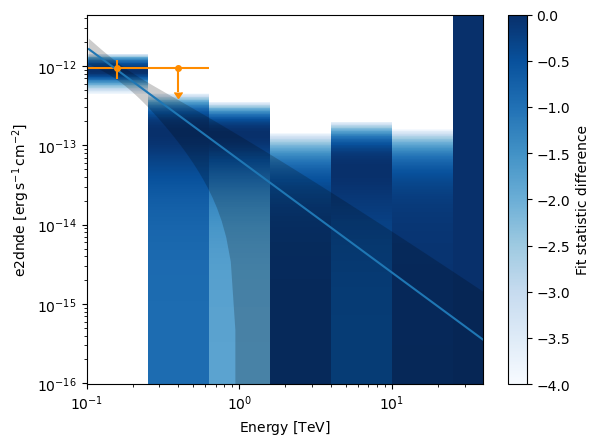

In [12]:
# Let's plot them, overlapping the significance
fig, ax = plt.subplots()
sed_type="e2dnde"
flux_points.plot(ax=ax, sed_type=sed_type, color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type=sed_type)
model.spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type)
model.spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type)
plt.show()

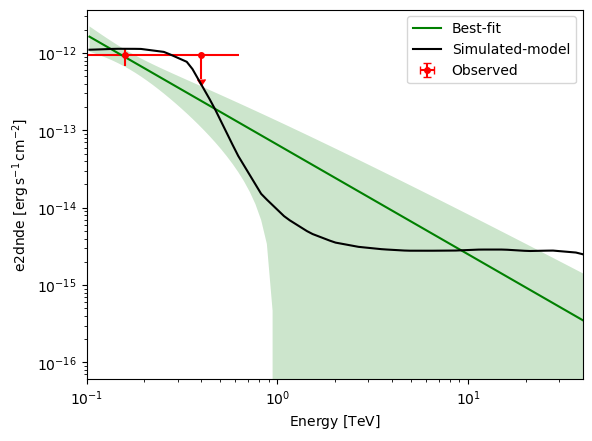

In [13]:
### We read the created file before 
models_original = Models.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/Wind_NGC_1068.yaml")     # lo fitto con una PL

# Let's plot the best-fit model and the spectral points
fig, ax = plt.subplots()
sed_type="e2dnde"
flux_points.plot(ax=ax, sed_type=sed_type, color="red", label="Observed")
model.spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, color="green", label="Best-fit")
model.spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, facecolor="green")
models_original[0].spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, color="black", label="Simulated-model")
#model.spectral_model.plot_error(ax=ax, energy_bounds=(2,10)*u.TeV, sed_type=sed_type, facecolor="green")

plt.legend()
#plt.ylim(2e-12,2e-10)
#plt.xlim(0.5,70)